<a href="https://colab.research.google.com/github/Jae2Wook/Machine-Learning-Class/blob/main/Copy_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip

# Combine the two traning directories
!echo "Mergining training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip

!echo "Data ready."

Unzipping files...
Mergining training data...
Cleaning up...
Data ready.


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as ftds
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist


In [ ]:
# Create an image training dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

# We're using keras' image_dataset_from_directory method to load our image data.
# See (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
training_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='training', seed=42, image_size=image_size)
validation_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='validation', seed=42, image_size=image_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


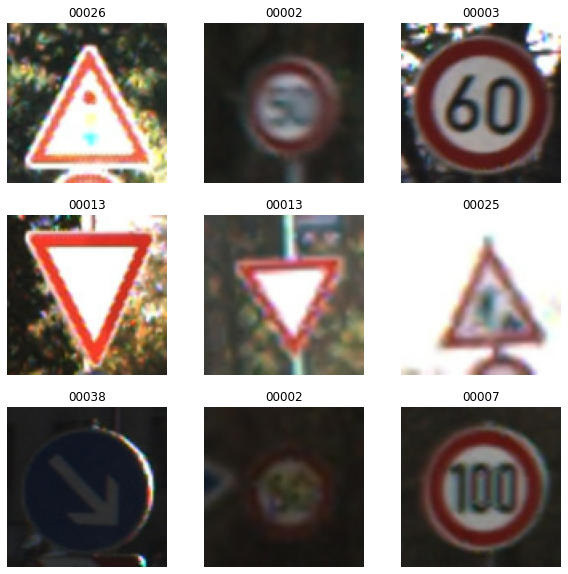

In [ ]:
import matplotlib.pyplot as plt

# View first 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(training_data.class_names[labels[i]])
    plt.axis("off")

Data Augmentation

In [ ]:
import random

def augmentation(train_data):
  data_augmentation = keras.Sequential([
   layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = [100, 100, 3]),
   layers.experimental.preprocessing.RandomRotation(0.3),
   layers.experimental.preprocessing.RandomCrop(100, 100)
  ])

  i = 0
  for images, labels in training_data:
    if i == 100:
      images = data_augmentation(images[random.randint(0,701)])
      i = 0
    else:
      i += 1
  return train_data

augmentation_training_data = augmentation(training_data)

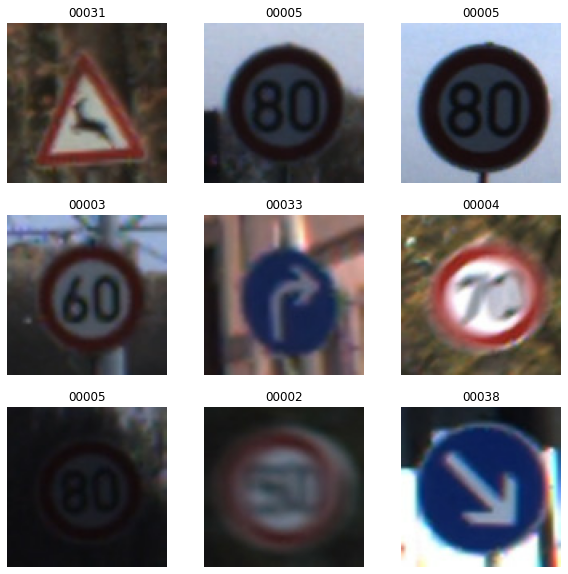

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in augmentation_training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(augmentation_training_data.class_names[labels[i]])
    plt.axis("off")

build model

In [ ]:
model = tf.keras.Sequential([
                             #first convolutional layer
                             layers.Conv2D(16, (3,3), activation = 'relu', padding = "same", input_shape = (100, 100, 3)),
                             layers.BatchNormalization(),
                             layers.Conv2D(16, (3,3), activation = 'relu', padding = "same"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(pool_size = 2, strides = 2),
                             layers.BatchNormalization(),
                             # 2nd convolutional layer
                             layers.Conv2D(32, (3,3),  activation = "relu", padding = "same"),
                             layers.BatchNormalization(),
                             layers.Conv2D(32, (3,3), activation = 'relu', padding = "same"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(pool_size = 2, strides = 2),
                             layers.BatchNormalization(),
                             # 3rd convolutional layer
                             layers.Conv2D(64, (3,3), activation = 'relu'),
                             layers.BatchNormalization(),
                             layers.Conv2D(64, (3,3), activation = "relu"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(pool_size = 2, strides = 2),
                             layers.BatchNormalization(),
                             # fully connected classifier
                             layers.Flatten(),
                             layers.Dense(2048, activation = 'relu'),
                             layers.Dense(1024, activation = 'relu'),
                             layers.Dense(128, activation = 'relu'),
                             layers.Dense(43, activation = "softmax")
])

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [ ]:
epochs = 5
history = model.fit(augmentation_training_data, batch_size = 64, epochs = epochs, validation_data = validation_data)

Epoch 1/5
981/981 [==============================] - 71s 39ms/step - loss: 1.2883 - accuracy: 0.6544 - val_loss: 0.0998 - val_accuracy: 0.9716
Epoch 2/5
981/981 [==============================] - 38s 38ms/step - loss: 0.0844 - accuracy: 0.9774 - val_loss: 0.0942 - val_accuracy: 0.9772
Epoch 3/5
981/981 [==============================] - 37s 38ms/step - loss: 0.0645 - accuracy: 0.9843 - val_loss: 0.1426 - val_accuracy: 0.9695
Epoch 4/5
981/981 [==============================] - 38s 38ms/step - loss: 0.0374 - accuracy: 0.9920 - val_loss: 0.0968 - val_accuracy: 0.9806
Epoch 5/5
981/981 [==============================] - 37s 38ms/step - loss: 0.0608 - accuracy: 0.9875 - val_loss: 0.0652 - val_accuracy: 0.9848


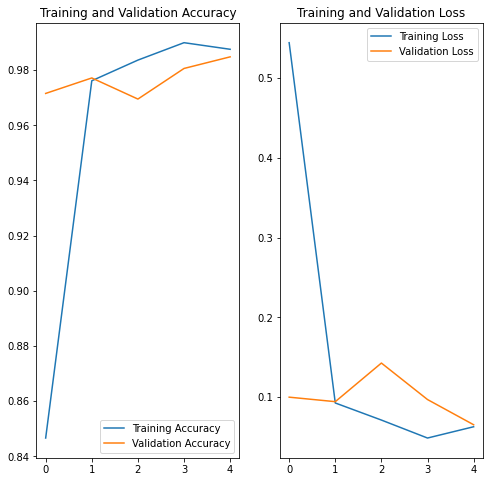

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, acc = model.evaluate(validation_data)
print("Accuracy", acc)

246/246 [==============================] - 5s 21ms/step - loss: 0.0652 - accuracy: 0.9848
Accuracy 0.9848233461380005


Noah

In [ ]:
## Checking the demetions and shape
for image_batch, labels_batch in training_data:
  print(image_batch[0].shape)
  print(labels_batch[0].shape)
  break

(100, 100, 3)
()


In [ ]:
## Confifureing dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = training_data.cache().shuffle(1500).prefetch(buffer_size = AUTOTUNE)
val_ds = validation_data.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
## Standarsize the data
### Giving a range based off of RGB channels 
from tensorflow.keras import layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
## More standarization 
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.019607844 0.45882356


In [ ]:
def getImages():
  imgArrayList = []
  dat = pd.read_csv("test/test_classes.csv")

  for fileName in dat.Filename:
    img = keras.preprocessing.image.load_img("test/" + filename, target_size=(100,100)) # make an image
    imgArrayList.append(tf.expand_dims(keras.preprocessing.image.img_to_array(img), 0))  # change into right format for model.predict
  return imgArrayList

def getPredictions():

SyntaxError: ignored

In [ ]:
## making new columns
dat["Predicted_Name"] = predictionsList
dat["Conf_Score"] = per_conf_score_list
dat["Predicted_Name"] = dat["Predicted_Name"].astype(int)

dat["Correct"] = dat.Predicted_Name == dat.ClassID

dat.Correct.value_counts()

In [ ]:
sns.scatterplot(data=dat, x="ClassId", y="Predicted_Name", alpha= .2)

In [ ]:
## Testing on the test dataset 
#1. Load that test csv file into a dataframe
#2. Create a loop, based on that data frame
#3. In the loop, load the file for that row, then run it through the model
#4. Use the argmax function to get the index of the prediction array with the highest probability
import pandas as pd

dat = pd.read_csv("test/test_classes.csv")

predictionsList = []
img_array = []

for fileName in dat.Filename:
  img = keras.preprocessing.image.load_img("test/" + filename, target_size=(100,100)) # make an image
  img_array.append(tf.expand_dims(keras.preprocessing.image.img_to_array(img), 0))  # change into right format for model.predict
  predictionsList.append(np.argmax(tf.nn.softmax(model.predict(img_array)[0]))) # append that prediction to the list


In [ ]:
## making new columns
dat["Predicted_Name"] = predictionsList
dat["Conf_Score"] = per_conf_score_list
dat["Predicted_Name"] = dat["Predicted_Name"].astype(int)

dat["Correct"] = dat.Predicted_Name == dat.ClassID

dat.Correct.value_counts()

In [ ]:
sns.scatterplot(data=dat, x="ClassId", y="Predicted_Name", alpha= .2)

In [ ]:
# Load a convolutional base with pre-trained weights
base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    pooling='avg')

# Freeze the base model
base_model.trainable = False

# Use a Sequential model to add a trainable classifier on top
Xception_model = keras.Sequential([
    base_model,
    layers.Dense(43),
])

Xception_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
Xception_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
#!pip install keras-rectified-adam

from keras_radam.training import RAdamOptimizer

# Load a convolutional base with pre-trained weights
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg')

In [ ]:
# Freeze the base model
base_model.trainable = False

# Use a Sequential model to add a trainable classifier on top
ResNet50_model = keras.Sequential([
    base_model,
    layers.Dense(43),
])

ResNet50_model.compile(optimizer=RAdamOptimizer(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
ResNet50_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
import pandas as pd

dat = pd.read_csv("test/test_classes.csv")
labels = list(dat.ClassId.to_list())



train_data = image_dataset_from_directory('/content/test', labels=labels, label_mode='int', seed=42, image_size=image_size)
